<h1><center>Лекція 3.</center></h1>
<h2><center>Традиційні методи класифікації: дерево рішень і метод найближчих сусідів</center></h2>

<a class="anchor" id="3"></a>

## Зміст 

1. [Дерево рішень](#3.1)
    - [Як будується дерево рішень](#3.1.1)
    - [Ентропія](#3.1.2)
    - [Алгоритм побудови дерева рішень](#3.1.3)
    - [Інші критерії якості розбиття в задачі класифікації](#3.1.4)
    - [Як дерево рішень працює з кількісними ознаками](#3.1.5)
    - [Основні параметри дерева](#3.1.6)
    - [Клас DecisionTreeClassifier в Scikit-learn](#3.1.7)
    - [Дерево рішень в задачі регресії](#3.1.8)
    - [Переваги та недоліки дерев рішень](#3.1.9)
2. [Метод найближчих сусідів](#3.2)
    - [Метод найближчих сусідів в реальних задачах](#3.2.1)
    - [Вибір параметрів моделі й крос-валідація](#3.2.2)
    - [Переваги та недоліки методу найближчих сусідів](#3.2.3)
3. [Дерева рішень і метод найближчих сусідів для задачі прогнозування відтоку клієнтів телеком-оператора](#3.3)
4. [Дерева рішень і метод найближчих сусідів для задачі розпізнавання рукописних цифр MNIST](#3.4)
5. [Складний випадок для дерев](#3.5)
6. [Складний випадок для методу найближчих сусідів](#3.6)
7. [Корисні покликання](#3.7)

У перших двох лекціях ми практикувалися в первинному аналізі даних з Python й зокрема Pandas і будували візуалізації, що дають змогу робити висновки за даними. Починаючи з цієї лекції ми нарешті перейдемо до інтелектуального аналізу даних (ІАД).

Перед тим як ринутися в бій, спершу поговоримо про те, яку саме задачу ми будемо вирішувати й яке її місце в галузі ІАД та машинного навчання (МН).

Класичне, загальне визначення МН звучить так (T. Mitchell "Machine learning", 1997): "кажуть, що комп'ютерна програма *навчається* під час розв'язання деякої задачі з класу *T*, якщо її продуктивність, відповідно до метрики *P*, покращується під час накопичення досвіду *E*".

Далі в різних сценаріях під *T*, *P*, і *E* маються на увазі зовсім різні речі. Серед найпопулярніших задач *T* в МН є:
 - класифікація - віднесення об'єкта до однієї з категорій на основі його ознак;
 - регресія - прогнозування кількісної ознаки об'єкта на основі інших його ознак;
 - кластеризація - розбиття множини об'єктів на групи на основі ознак цих об'єктів так, щоб усередині груп об'єкти були схожі між собою, а поза однієї групи - менш схожі;
 - детектування аномалій - пошук об'єктів, "дуже несхожих" на всі інші у вибірці або на якусь групу об'єктів;
 - і багато інших, більш специфічних.
 
Хороший огляд дано в 5 розділі книги ["Deep Learning"](https://www.deeplearningbook.org/) (Ian Goodfellow, Yoshua Bengio, Aaron Courville, 2016).
 
Під досвідом *E* розуміють дані (без них нікуди), і в залежності від цього алгоритми ІАД можуть бути поділені на ті, що навчаються *з учителем* і *без учителя* ([supervised](https://en.wikipedia.org/wiki/Supervised_learning) & [unsupervised learning](https://en.wikipedia.org/wiki/Unsupervised_learning), відповідно). У задачах навчання без учителя є *вибірка*, що складається з *об'єктів*, що описується набором *ознак*. У задачах навчання з учителем на додачу до цього для кожного об'єкта деякої вибірки, що зветься *навчальна*, відома *цільова ознака* - те, що хотілося б прогнозувати для інших об'єктів, не з навчальної вибірки.

#### Приклад

Задачі класифікації й регресії - це задачі навчання з учителем. За приклад візьмемо задачу кредитного скорингу: на основі накопичених банком даних щодо своїх клієнтів є потреба спрогнозувати потенційне неповернення кредиту. Тут для алгоритму досвід *E* - це наявна навчальна вибірка: набір *об'єктів* (людей), кожен з яких характеризується набором *ознак* (таких як вік, зарплата, тип кредиту, неповернення в минулому тощо), а також *цільовою ознакою*. Якщо ця цільова ознака є фактом неповернення кредиту (1 або 0, тобто банк знає про своїх клієнтів, хто повернув кредит, а хто - ні), то це задача (бінарної) класифікації. Якщо відомо, *на скільки* за часом клієнт затягнув з поверненням кредиту та хочеться те ж саме спрогнозувати для нових клієнтів, то це буде задачею регресії.

Нарешті, третя абстракція у визначенні ІАД та МН - це метрика оцінки продуктивності алгоритму *P*. Такі метрики відрізняються для різних задач й алгоритмів, і про них ми поговоримо в наступних темах. Наразі будемо говорити, що найпростішою метрикою якості алгоритму, що розв'язує задачу класифікації, є частка правильних відповідей (*accuracy*) - тобто частка правильних прогнозів алгоритму на тестовій вибірці.

Далі детальніше розглянемо дві задачі навчання з учителем: про класифікацію та регресcію.

<a class="anchor" id="3.1"></a>

## <span style="color:blue; font-size:1.2em;">3.1. Дерево рішень</span>

[Повернутися до змісту](#3)

Почнемо огляд методів класифікації та регресії з одного з найпопулярніших - з дерева рішень. Розроблення та удосконалення методу дерева рішень відбувалося протягом всього XX століття ([коротка історія](https://www.explorium.ai/blog/the-complete-guide-to-decision-trees/)). Цей метод використовуються в повсякденному житті в найрізноманітніших галузях людської діяльності, часом і дуже далеких від ІАД та МН. Деревом рішень можемо називати наочну інструкцію, що робити в тій чи іншій ситуації. Наведемо приклад з галузі консультування наукових співробітників інституту. Припускаємо що Хмельницький національний університет випускає інфо-схему, що полегшує життя своїм співробітникам. Ось фрагмент інструкції щодо публікацій наукової статті на порталі університету.

![image](https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/3_decision-tree_proto.png)

В термінах МН можна сказати, що зображення вище є елементарним класифікатором, який визначає форму публікації на порталі (книга, стаття, розділ книги, препринт, публікація у "Віснику ХНУ") за кількома ознаками: типом публікації (монографія, брошура, стаття тощо), типом видання, де опублікована стаття (науковий журнал, збірник праць тощо) та іншими.

Найчастіше дерево рішень слугує узагальненням досвіду експертів, засобом передачі знань майбутнім співробітникам або моделлю бізнес-процесу компанії. Наприклад, до впровадження масштабованих алгоритмів МН в банківській сфері завдання кредитного скорингу розв'язувалось експертами. Рішення щодо видачі кредиту позичальникові приймалося на основі деяких інтуїтивно (або з досвіду) виведених правил, які можна подати у вигляді дерева рішень.

![image](https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/3_decision-tree_example.gif)

Дерево рішень як алгоритм ІАД/МН - де факто те ж саме: об'єднання логічних правил виду "Значення ознаки $a$ менше $x$ і значення ознаки $b$ менше $y$ ... => Клас 1" в структуру даних "Дерево ". Величезна перевага дерев рішень в тому, що вони легко інтерпретуються і є зрозумілими людині. Наприклад, за схемою на рисунку вище можна пояснити позичальнику, чому йому було відмовлено в кредиті: тому що у нього немає будинку і дохід менше 5000.

Як ми побачимо далі, багато інших, хоч і більш точних, моделей не мають цієї властивості, і можуть розглядатися швидше, як "чорний ящик", в який ми просто завантажили дані й отримали відповідь. Через цю "зрозумілістю" дерев рішень і їх схожість з моделлю прийняття рішень людиною (можна легко пояснювати керівнику свою модель), дерева рішень отримали широку популярність, а один з представників цієї групи методів класифікації, С4.5, розглядається першим в списку 10 кращих алгоритмів ІАД ("Top 10 algorithms in data mining", Knowledge and Information Systems, 2008. [PDF](https://www.researchgate.net/publication/29467751_Top_10_algorithms_in_data_mining)).

<a class="anchor" id="3.1.1"></a>

### <span style="color:blue; font-size:1em;">3.1.1. Як будується дерево рішень</span>

[Повернутися до змісту](#3)

У прикладі з кредитного скорингу ми бачили, що рішення щодо видачі кредиту приймалося на основі віку, наявності нерухомості, доходу та інших ознак. Але яку ознаку варто обрати першою? Для відповіді на це питання розглянемо приклад простіше, де всі ознаки є бінарними.

Тут можна згадати гру "20 запитань", яка часто згадується у вступі в дерева рішень. Напевно кожен в неї грав. Одна людина загадує, наприклад, знаменитість, а інша намагається відгадати, задаючи лише ті питання, на які можна відповісти "Так" або "Ні" (опустимо варіанти "не знаю" і "не можу сказати"). В такому разі, яке питання насамперед задасть людина, що відгадує? Звичайно те, яке найсильніше зменшить кількість варіантів, що залишилися. Наприклад, питання "Це Анджеліна Джолі?" в разі негативної відповіді залишить понад 7 мільярдів варіантів для подальшого перебору (звичайно, трохи менше, не кожна людина - знаменитість, але все одно чимало), а ось питання "Це жінка?" відсіче вже близько половини знаменитостей. Тобто ознака "стать" набагато краще розділяє вибірку людей, ніж ознака "це Анджеліна Джолі", "національність-іспанець" або "любить футбол". Це інтуїтивно відповідає поняттю приросту інформації, що ґрунтується на ентропії.

<a class="anchor" id="3.1.2"></a>

### <span style="color:blue; font-size:1em;">3.1.2. Ентропія</span>

[Повернутися до змісту](#3)

Ентропія Шеннона визначається для системи з $N$ можливими станами так:

$$S = -\sum_{i=1}^{N}p_ilog_2p_i,$$

де $p_i$ - ймовірності перебування системи в $i$-му стані.

Ентропія є вкрай важливим поняттям, яке використовується в фізиці, теорії інформації та інших галузях. Опускаючи передумови вступу (комбінаторні і теоретико-інформаційні) цього поняття, зазначимо, що інтуїтивно ентропія відповідає ступеню хаосу в системі. Чим вище значення ентропії, тим менше система впорядкована і навпаки. Це допоможе нам формалізувати "ефективний розподіл вибірки", про яке ми говорили в контексті гри "20 запитань".

#### Приклад

Для ілюстрації того, як ентропія допоможе визначити хороші ознаки для побудови дерева, наведемо іграшковий приклад із статті ["Энтропия и деревья принятия решений"](https://habrahabr.ru/post/171759/). Тут будемо передбачати колір кульки за його координатою. Звичайно, нічого спільного з реальним життям цей приклад немає, але дає змогу показати, як ентропія використовується для побудови дерева рішень.

![image](https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/3_decision-tree_circles_1.png)

Маємо 9 синіх кульок і 11 жовтих. Якщо ми навмання витягли кульку, то вона з ймовірністю $p_1=\frac{9}{20}$ буде синьою і з ймовірністю $p_2=\frac{11}{20}$ - жовтою. Відтак, ентропія стану становить:

$$S_0 = -\frac{9}{20}log_2{\frac{9}{20}}-\frac{11}{20}log_2{\frac{11}{20}} \approx 1$$.

Це значення наразі ні про що нам не говорить. Але далі  подивимося, як зміниться ентропія, якщо розбити кульки на дві групи - з координатою менше або дорівнює 12 і більше 12.

![image](https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/3_decision-tree_circles_2.png)

У лівій групі виявилося 13 кульок, з яких 8 синіх і 5 жовтих. Ентропія цієї групи дорівнює:

$$S_1 = -\frac{5}{13}log_2{\frac{5}{13}}-\frac{8}{13}log_2{\frac{8}{13}} \approx 0.96.$$

У правій групі виявилося 7 куль, з яких 1 синій і 6 жовтих. Ентропія правої групи становить:

$$S_2 = -\frac{1}{7}log_2{\frac{1}{7}}-\frac{6}{7}log_2{\frac{6}{7}} \approx 0.6.$$

Як бачимо, ентропія зменшилася в обох групах у порівнянні з початковим станом, хоча в лівій і не сильно. Оскільки ентропія - де факто ступінь хаосу (або невизначеності) в системі, зменшення ентропії називають приростом інформації. Формально приріст інформації (аенл. "information gain", IG) при розбитті вибірки за ознакою $Q$ (в нашому прикладі це ознака "$x \leq 12$") визначається як

$$IG(Q) = S_O - \sum_{i=1}^{q}\frac{|N_i|}{N}S_i,$$

де $q$ - кількість груп після розбиття, $N_i$ - кількість елементів вибірки, у яких ознака $Q$ має $i$-е значення.
У нашому випадку після поділу вийшло дві групи ($q = 2$) - одна з 13 елементів ($N_1 = 13$), друга - з 7 ($N_2 = 7$).

Приріст інформації становить:

$$IG("x \leq 12") = S_0 - \frac{13}{20}S_1 - \frac{7}{20}S_2 \approx 0.16.$$

Отримали, що розділивши кульки на дві групи за ознакою "координата менше або дорівнює 12", ми вже отримали більш впорядковану систему, ніж на початку. Продовжимо розподіл кульок допоки в кожній групі кульки не будуть одного кольору.

![image](https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/3_decision-tree_circles_3.png)

Для правої групи було потрібно всього одне додаткове розбиття за ознакою "координата менше або дорівнює 18", для лівої - ще три. Очевидно, ентропія групи з кульками одного кольору дорівнює 0 ($log_2{1} = 0$), що відповідає уявленню, що група кульок одного кольору - впорядкована.

У підсумку ми побудували дерево рішень, яке пророкує колір кульки за його координатою. Зазначимо, що таке дерево рішень може погано працювати для нових об'єктів (визначення кольору нових кульок), оскільки воно ідеально підлаштоване під навчальну вибірку (початкові 20 кульок). Для класифікації нових кульок краще підійде дерево з меншим числом "питань", або поділів, навіть якщо воно й неідеально розбиває навчальну вибірку за кольором. Цю проблему, що зветься перенавчанням, ми розглянемо далі.

<a class="anchor" id="3.1.3"></a>

### <span style="color:blue; font-size:1em;">3.1.3. Алгоритм побудови дерева</span>

[Повернутися до змісту](#3)

Можемо переконатися в тому, що побудоване в попередньому прикладі дерево є в деякому сенсі оптимальним - треба було лише 5 "питань" (умов для ознаки $x$), щоб "підігнати" дерево рішень під навчальну вибірку, тобто щоб дерево правильно класифікувало будь-який навчальний об'єкт. За інших умов поділу вибірки дерево вийде глибше.

Популярні алгоритми побудови дерева рішень, такі як [ID3](https://en.wikipedia.org/wiki/ID3_algorithm) і [C4.5](https://en.wikipedia.org/wiki/C4.5_algorithm), ґрунтуються на принципі жадібної максимізації приросту інформації - на кожному кроці вибирається та ознака, при поділі за якою приріст інформації виявляється найбільшим. Далі процедура повторюється рекурсивно, поки ентропія не дорівнюватиме нулю або якійсь малій величині (якщо дерево не підганяється ідеально під навчальну вибірку, щоб уникнути перенавчання).

У різних алгоритмах використовуються різні [евристики](https://uk.wikipedia.org/wiki/%D0%95%D0%B2%D1%80%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B8%D0%B9_%D0%B0%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC) для "ранньої зупинки" або "відсікання", щоб уникнути побудови перенавчання дерева.

<a class="anchor" id="3.1.4"></a>

### <span style="color:blue; font-size:1em;">3.1.4. Інші критерії якості розбиття в задачі класифікації</span>

[Повернутися до змісту](#3)

Наразі ми розібралися в тому, як поняття ентропії дає змогу формалізувати уявлення про якість розбиття в дереві рішень. Але тут ентропія є лише евристикою; можуть використовуватися й інші:

- Невизначеність Джині (Gini impurity):

$$G = 1 - \sum\limits_k (p_k)^2$$.

Максимізацію цього критерію можна інтерпретувати як максимізацію числа пар об'єктів одного класу, які опинилися в одному піддереві. Не плутати з [коефіцієнтом Джині](https://uk.wikipedia.org/wiki/%D0%9A%D0%BE%D0%B5%D1%84%D1%96%D1%86%D1%96%D1%94%D0%BD%D1%82_%D0%94%D0%B6%D0%B8%D0%BD%D1%96)! Детальніше про термінологія Джині – в [блогпості](https://alexanderdyakonov.wordpress.com/2015/12/15/%D0%B7%D0%BD%D0%B0%D0%BA%D0%BE%D0%BC%D1%8C%D1%82%D0%B5%D1%81%D1%8C-%D0%B4%D0%B6%D0%B8%D0%BD%D0%B8/) Олександра Дьяконова.
- Помилка класифікації (misclassification error):

$$E = 1 - \max\limits_k p_k$$.

На практиці помилка класифікації майже не використовується, а невизначеність Джині і приріст інформації працюють майже однаково.

У разі задачі бінарної класифікації ($p_+$ - ймовірність об'єкта мати мітку +) ентропія і невизначеність Джині приймуть такий вигляд:<br> <br>

$$ S = -p_+ \log_2{p_+} -p_- \log_2{p_-} = -p_+ \log_2{p_+} -(1 - p_{+}) \log_2{(1 - p_{+})};$$
$$ G = 1 - p_+^2 - p_-^2 = 1 - p_+^2 - (1 - p_+)^2 = 2p_+(1-p_+).$$

Якщо ми побудуємо графіки цих двох функцій від аргументу $p_+$, то побачимо, що графік ентропії дуже близький до графіка подвоєної невизначеності Джині, і тому на практиці ці два критерії "працюють" майже однаково.

Далі опрацюємо алгоритми побудови дерева рішень за допомогою інструментів Python.

In [1]:
from __future__ import division, print_function

# Відключимо різні попередження Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pylab as plt
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

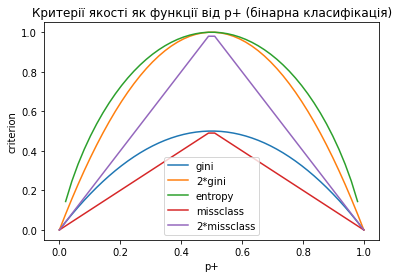

In [2]:
plt.rcParams['figure.figsize'] = (6,4)
xx = np.linspace(0,1,50)
plt.plot(xx, [2 * x * (1-x) for x in xx], label='gini')
plt.plot(xx, [4 * x * (1-x) for x in xx], label='2*gini')
plt.plot(xx, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in xx], label='entropy')
plt.plot(xx, [1 - max(x, 1-x) for x in xx], label='missclass')
plt.plot(xx, [2 - 2 * max(x, 1-x) for x in xx], label='2*missclass')
plt.xlabel('p+')
plt.ylabel('criterion')
plt.title('Критерії якості як функції від p+ (бінарна класифікація)')
plt.legend();

#### Приклад

Розглянемо приклад застосування дерева рішень з бібліотеки Scikit-learn для синтетичних даних. Спершу згенеруємо дані. Два класи будуть згенеровані з двох нормальних розподілів з різними середніми значеннями.

In [88]:
# створюємо перший клас
np.seed = 7
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# додаємо другий клас
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

Напишемо допоміжну функцію, яка буде повертати решітку для подальшої файної візуалізації.

In [89]:
def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps), np.arange(y_min, y_max, eps))

Відобразимо дані. Неформально, задача класифікації в цьому випадку полягає в побудові "хорошої" границі, що розділяє два класа (червоні точки від жовтих). Простими словами, МН в цьому випадку зводиться до того, як вибрати хорошу границю, що розділяє точки між собою. Можливо, звичайна пряма лінія буде занадто простою границею, а якась складна крива, що обгинає кожну червону крапку - буде занадто складною. В такому разі ми будемо багато разів помилятися на нових прикладах з того ж розподілу, з якого прийшла навчальна вибірка. Інтуїція підказує, що на нових даних добре працюватиме *гладка* границя, що розділяє 2 класи, або хоча б просто пряма (в $n$-мірному випадку - гіперплощина).

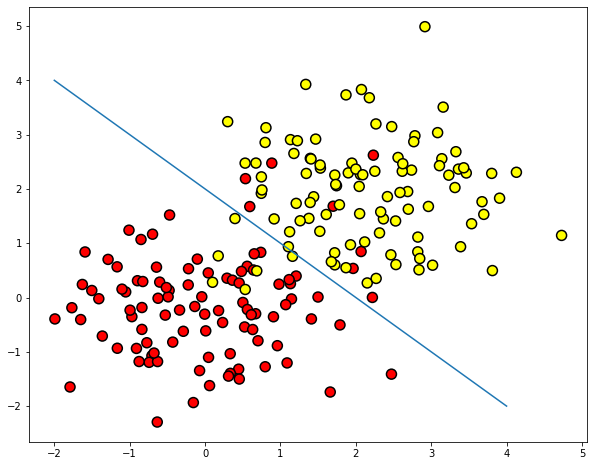

In [90]:
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.plot(range(-2,5), range(4,-3,-1));

Спробуємо розділити ці два класи, навчивши дерево рішень. У дереві будемо використовувати параметр `max_depth`, що обмежує глибину дерева. Візуалізуємо отриману границю поділу класів.

Для реалізації дерева рішень використаємо клас `DecisionTreeClassifier` з бібліотеки Scikit-learn.

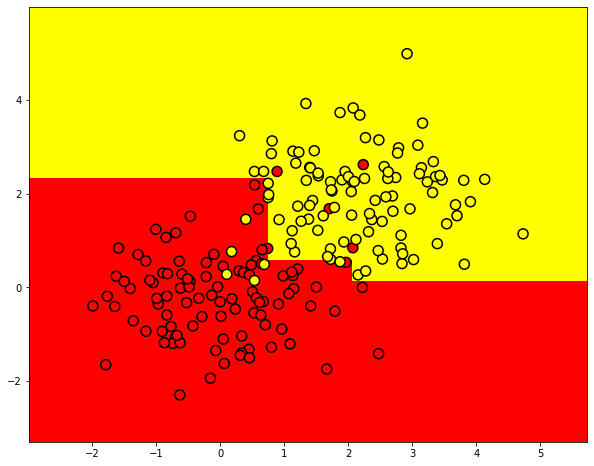

In [91]:
from sklearn.tree import DecisionTreeClassifier

# параметр min_samples_leaf вказує, за якої мінімальної кількості
# елементів у вузлі лист буде далі поділятися
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

# навчаємо дерево
clf_tree.fit(train_data, train_labels)

# трохи програмного коду для відображення поверхні, що розділяє на класи
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100,
            cmap='autumn', edgecolors='black', linewidth=1.5);

Добре, а як виглядає саме побудоване дерево? Бачимо, що дерево "нарізає" простір на 7 прямокутників (у дереві 7 листків). У кожному такому прямокутнику прогноз дерева буде сталим, за переважанням об'єктів того чи іншого класу.

In [92]:
# використовуємо .dot формат для візуалізації дерева
from ipywidgets import Image
from io import StringIO
import pydotplus
from sklearn.tree import export_graphviz

dot_data = StringIO()
export_graphviz(clf_tree, feature_names=['x1', 'x2'], 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xa3\x00\x00\x01\xf1\x08\x06\x00\x00\x00\x98\xbfj…

Давайте "прочитаємо" це дерево.

На початку аналізу було 200 об'єктів, 100 - одного класу і 100 - другого. Ентропія початкового стану була максимальною - 1. Потім було зроблено розбиття об'єктів на 2 групи залежно від порівняння ознаки $x_1$ зі значенням $0.3631$ (спробуйте знайти цю ділянку границі на рисунку вище, до відображення дерева). Водночас ентропія і в лівій, і в правій групі об'єктів зменшилася. І так далі, дерево будується до глибини 3. За такої візуалізації чим більше об'єктів одного класу, тим колір вершини ближче до темно-помаранчевого і, навпаки, чим більше об'єктів другого класу, тим ближче колір до темно-синього. На початку об'єктів одного класу є рівна кількість, тому коренева вершина дерева - білого кольору.

<a class="anchor" id="3.1.5"></a>

### <span style="color:blue; font-size:1em;">3.1.5. Як дерево рішень працює з кількісними ознаками</span>

[Повернутися до змісту](#3)

Нехай у вибірці є кількісна ознака "Вік", яка має багато унікальних значень. Дерево рішень буде шукати краще (за критерієм типу приросту інформації) розбиття вибірки, перевіряючи бінарні ознаки на зразок "Вік < 17", "Вік < 22.87" тощо. Проте, що коли таких "нарізань" віку занадто багато? А що коли є ще кількісна ознака "Зарплата", і зарплату теж можна «нарізати» великим числом способів? Виходить дуже багато бінарних ознак для вибору кращої на кожному кроці побудови дерева. Для вирішення цієї проблеми застосовують евристики для обмеження числа порогів, з якими ми порівнюємо кількісну ознаку.

Розглянемо кількісні ознаки дерева рішень на іграшковому прикладі. Нехай є наступна вибірка:

In [93]:
data = pd.DataFrame({'Вік': [17,64,18,20,38,49,55,25,29,31,33], 
             'Неповернення кредиту': [1,0,1,0,1,0,0,1,1,0,1]})

In [94]:
data

,Вік,Неповернення кредиту
0,17,1
1,64,0
2,18,1
3,20,0
4,38,1
5,49,0
6,55,0
7,25,1
8,29,1
9,31,0


Відсортуємо її за зростанням віку.

In [95]:
data.sort_values('Вік')

,Вік,Неповернення кредиту
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


Навчимо на цих даних дерево рішень (без обмеження глибини) і подивимося на нього.

In [96]:
age_tree = DecisionTreeClassifier(random_state=17)
age_tree.fit(data['Вік'].values.reshape(-1, 1), data['Неповернення кредиту'].values)

DecisionTreeClassifier(random_state=17)

Бачимо, що дерево задіяло 5 значень, з якими порівнюється вік: 43.5, 19, 22.5, 30 і 32 роки. Якщо придивитися, то це якраз середні значення між роками, за яких цільовий клас "змінюється" з 1 на 0 або навпаки. Складна фраза, тому приклад: 43.5 - це середнє між 38 і 49 роками; клієнт, якому 38 років, не повернув кредит, а той, якому 49 - повернув. Аналогічно, 19 років - середнє між 18 і 20 роками. Тобто за порогами для "нарізання" кількісної ознаки дерево "дивиться" на ті значення, за яких цільовий клас змінює своє значення.

Подумайте, чому не має сенсу в даному випадку розглядати ознаку "Вік < 17.5".

In [97]:
dot_data = StringIO()
export_graphviz(age_tree, feature_names=['Вік'], 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xed\x00\x00\x03\x07\x08\x06\x00\x00\x00\x14\xf4\…

<!--
export_graphviz(age_tree, feature_names=['Возраст'], 
                out_file='../../img/age_tree.dot', filled=True)
!dot -Tpng '../../img/age_tree.dot' -o '../../img/age_tree.png'
<img src='../../img/age_tree.png'>
-->

Розглянемо приклад складніше: додамо ознаку "Зарплата" (тис. грн/місяць).

In [98]:
data2 = pd.DataFrame({'Вік':  [17,64,18,20,38,49,55,25,29,31,33], 
                      'Зарплата': [7.5,32,6,14.5,15,24,30,9.5,13,41,35], 
             'Неповернення кредиту': [1,0,1,0,1,0,0,1,1,0,1]})

In [99]:
data2

,Вік,Зарплата,Неповернення кредиту
0,17,7.5,1
1,64,32.0,0
2,18,6.0,1
3,20,14.5,0
4,38,15.0,1
5,49,24.0,0
6,55,30.0,0
7,25,9.5,1
8,29,13.0,1
9,31,41.0,0


Якщо впорядкувати за віком, то цільової клас ("Неповернення кредиту") змінюється (з 1 на 0 або навпаки) 5 разів. А якщо впорядкувати за зарплатою - то 7 разів. Як тепер дерево буде обирати ознаки? Давайте подивимося.

In [100]:
data2.sort_values('Вік')

,Вік,Зарплата,Неповернення кредиту
0,17,7.5,1
2,18,6.0,1
3,20,14.5,0
7,25,9.5,1
8,29,13.0,1
9,31,41.0,0
10,33,35.0,1
4,38,15.0,1
5,49,24.0,0
6,55,30.0,0


In [101]:
data2.sort_values('Зарплата')

,Вік,Зарплата,Неповернення кредиту
2,18,6.0,1
0,17,7.5,1
7,25,9.5,1
8,29,13.0,1
3,20,14.5,0
4,38,15.0,1
5,49,24.0,0
6,55,30.0,0
1,64,32.0,0
10,33,35.0,1


In [102]:
age_sal_tree = DecisionTreeClassifier(random_state=17)
age_sal_tree.fit(data2[['Вік', 'Зарплата']].values, data2['Неповернення кредиту'].values);

In [103]:
dot_data = StringIO()
export_graphviz(age_sal_tree, feature_names=['Вік', 'Зарплата'], 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01]\x00\x00\x01\xf1\x08\x06\x00\x00\x00\xceVo"\x00\…

<!--
export_graphviz(age_sal_tree, feature_names=['Возраст', 'Зарплата'], 
                out_file='../../img/age_sal_tree.dot', filled=True)
!dot -Tpng '../../img/age_sal_tree.dot' -o '../../img/age_sal_tree.png'
<img src='../../img/age_sal_tree.png'>
-->

Бачимо, що в дереві задіяні як розбиття за віком, так і за зарплатою. Водночас пороги, з якими порівнюються ознаки: 43.5 і 22.5 років - для віку і **95 і 30.5 тис. Руб / міс** - для зарплати. І знову можна помітити, що 95 тис. - це середнє між 88 і 102, водночас людина із зарплатою 88 виявилась "неблагонадійною", а з 102 - "благонадійною". Те ж саме для 30.5 тис. Тобто перебиралися порівняння зарплати й віку не з усіма можливими значеннями, а тільки з кількома. А чому в дереві виявилися саме ці ознаки? Тому що за ними розбиття виявилося кращими (за критерієм невизначеності Джині).

**Висновок:** найпростіша евристика для оброблення кількісних ознак в дереві рішень: кількісна ознака сортується за зростанням, і в дереві перевіряються тільки ті пороги, за яких цільова ознака змінює значення. Звучить не дуже строго, але іграшкові приклади мали б краще прояснити ситуацію з ознаками.

Додатково, коли дані містять багато кількісних ознак, і у кожної ознаки є багато унікальних значень, то можуть відбиратися не всі пороги, що описані вище, а тільки топ-N, що дають максимальний приріст до того ж критерію. Тобто для кожного порога будується дерево з глибиною 1, рахується зміна ентропії (або невизначеність Джині) і вибираються тільки найкращі пороги, з якими варто порівнювати кількісну ознаку.

Для ілюстрації: при розбитті за ознакою "Зарплата $\leq$ 34.5" в лівій підгрупі ентропія 0 (всі клієнти "погані"), а в правій - 0.954 (3 "поганих" і 5 "хороших"). Приріст інформації виходить близько 0.3. При розбитті за ознакою "Зарплата $\leq$ 95" в лівій підгрупі ентропія 0.97 (6 "поганих" і 4 "хороших"), а в правій - 0 (всього один об'єкт). Приріст інформації виходить приблизно 0.11.

Порахувавши у такий спосіб приріст інформації для кожного розбиття, можна попередньо, до побудови великого дерева (за всіма ознаками) відібрати пороги, з якими буде порівнюватися кожна кількісна ознака.

Приклади дискретизації кількісних ознак можна переглянути в постах, наприклад, [цьому](http://kevinmeurer.com/a-simple-guide-to-entropy-based-discretization/) і [цьому](https://brandewinder.com/2013/05/26/Discretizing-a-continuous-variable-using-Entropy/). Одна з найвідоміших наукових статей на цю тему – "On the handling of continuous-valued attributes in decision tree generation" (U.M. Fayyad. K.B. Irani, "Machine Learning", 1992), [PDF](https://link.springer.com/content/pdf/10.1007/BF00994007.pdf).

<a class="anchor" id="3.1.6"></a>

### <span style="color:blue; font-size:1em;">3.1.6. Основні параметри дерева</span>

[Повернутися до змісту](#3)

В принципі дерево рішень можна побудувати до такої глибини, щоб в кожному листку був рівно один об'єкт. Але на практиці це не робиться через те, що таке дерево буде *перенавченим* - воно занадто налаштується на навчальну вибірку і буде погано прогнозувати на нових даних. Десь внизу дерева, на великій глибині, будуть з'являтися розбиття за менш важливими ознаками (наприклад, приїхав клієнт з Хмельницького чи Львова). Якщо спрощувати, може виявитися так, що з усіх 4 клієнтів, які прийшли в банк за кредитом в зелених штанях, ніхто не повернув кредит і можна зробити висновок, що колір штанів клієнта має вплив на його "благонадійність". Очевидно, ми не хочемо, щоб наша модель класифікації породжувала такі специфічні та упереджені правила.
 
Є два винятки, за яких дерева будуються до максимальної глибини:

 - випадковий ліс (композиція багатьох дерев) уреденює відповіді дерев, що побудовані до максимальної глибини (про те, чому варто робити саме так, поговоримо в наступних темах);
 - стрижка дерева (з англ. *pruning*); за такого підходу дерево спочатку будується до максимальної глибини, а далі поступово, від низу до верху, деякі вершини дерева прибираються через порівняння за якістю дерева з даними розбиттям і без нього (порівняння проводиться за допомогою *крос-валідаці*, про яку трохи нижче).

Картинка нижче - приклад границі, що розділяє класи, і побудована перенавченим деревом.

![image](https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/3_decision-tree_overfitted-tree.png)

Основні способи боротьби з перенавчанням для дерев рішень:
 - штучне обмеження глибини або мінімальної кількості об'єктів в листі: побудова дерева в певний момент просто припиняється;
 - стрижка дерева (з англ. *pruning*); за такого підходу дерево спочатку будується до максимальної глибини, а далі поступово, від низу до верху, деякі вершини дерева прибираються через порівняння за якістю дерева з даними розбиттям і без нього (порівняння проводиться за допомогою *крос-валідаці*, про яку трохи нижче).
 
Детальніше про проблему пере- та недонавчання дерев рішень можна почитати в [блозі](https://neptune.ai/blog/overfitting-vs-underfitting-in-machine-learning).

<a class="anchor" id="3.1.7"></a>

### <span style="color:blue; font-size:1em;">3.1.7. Клас DecisionTreeClassifier в Scikit-learn</span>

[Повернутися до змісту](#3)

Основні параметри класу [sklearn.tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html):

 - `max_depth`: максимальна глибина дерева;
 - `max_features`: максимальна кількість ознак, за якими шукається краще розбиття в дереві (це потрібно, тому що за великої кількості ознак буде "дорого" шукати краще (за критерієм приросту інформації) розбиття серед *всіх* ознак);
 - `min_samples_leaf`: мінімальна кількість об'єктів в листі; у цього параметра є зрозуміла інтерпретація: скажімо, якщо він дорівнює 5, то дерево буде породжувати тільки ті правила класифікації, які є правильними як мімімум для 5 об'єктів.

Параметри дерева треба налаштовувати залежно від вхідних даних, і робиться це зазвичай за допомогою *крос-валідації*, про яку згодом.

<a class="anchor" id="3.1.8"></a>

### <span style="color:blue; font-size:1em;">3.1.8. Дерево рішень в задачі регресії</span>

[Повернутися до змісту](#3)

Під час прогнозування кількісної ознаки ідея побудови дерева залишається такою ж, як для класифікації, але змінюється критерій якості - дисперсія навколо середнього:
 
 $$D = \frac{1}{\ell} \sum\limits_{i =1}^{\ell} (y_i - \frac{1}{\ell} \sum\limits_{j=1}^{\ell} y_j)^2,$$
 
де $\ell$ – кількість об'єктів в листі; $y_i$ – значення цільової ознаки.

Іншими словами, мінімізуючи дисперсію навколо середнього, ми шукаємо ознаки, що розбивають вибірку так, що значення цільової ознаки в кожному листі приблизно рівні.

#### Приклад

Згенеруємо дані, що розподілені навколо функції $f(x) = e^{-x ^ 2} + 1.5 * e^{-(x - 2) ^ 2}$ c деякими шумом.

In [104]:
n_train = 150        
n_test = 1000       
noise = 0.1

def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + \
        np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

In [105]:
from sklearn.tree import DecisionTreeRegressor
     
reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

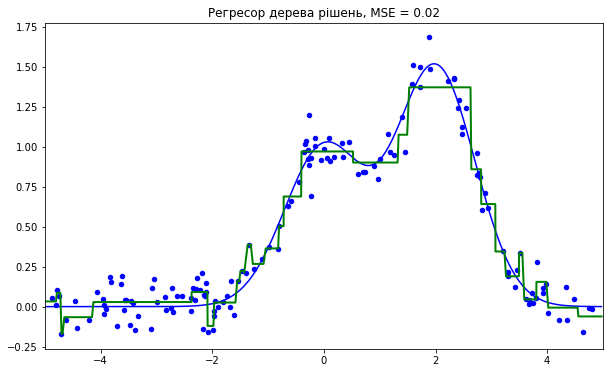

In [106]:
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Регресор дерева рішень, MSE = %.2f" % (np.sum((y_test - reg_tree_pred) ** 2) / n_test))
plt.show()

Бачимо, що дерево рішень апроксимує залежність в даних кусково-постійною функцією.

<a class="anchor" id="3.1.9"></a>

### <span style="color:blue; font-size:1em;">3.1.9. Переваги та недоліки дерев рішень</span>

[Повернутися до змісту](#3)

**Переваги:**
 - породження чітких правил класифікації, що є зрозумілими людині; наприклад, "якщо вік < 25 та є інтерес до мотоциклів, то відмовити в кредиті"; цю властивість називають інтерпретованістю моделі;
 - дерева рішень можна легко візуалізувати, тобто може "інтерпретуватися" як сама модель (дерево), так і прогноз для окремого взятого тестового об'єкта (шлях в дереві);
 - швидкі процеси навчання й прогнозування;
 - мала кількість параметрів моделі;
 - підтримка як числових, так і категоріальних ознак.
 
**Недоліки:** 
 - у породження чітких правил класифікації присутня інша сторона медалі: дерева дуже чутливі до шумів у вхідних даних, тобто вся модель може кардинально змінитися, якщо трохи зміниться навчальна вибірка (наприклад, якщо прибрати одну з ознак або додати кілька нових об'єктів), тому і правила класифікації можуть сильно змінюватися, що погіршує інтерпретованість моделі;
 - розділяюча межа, що побудована деревом рішень, має свої обмеження (складається з гіперплощин, що перпендикулярні якійсь і координатних осей); тому на практиці дерево рішень за якістю класифікації (наприклад, частка правильних позначень) поступається деяким іншим методам;
 - нестабільність: невеликі зміни в даних можуть суттєво змінювати побудоване дерево рішень; з цією проблемою борються за допомогою ансамблів дерев рішень (розглянемо в наступних темах);
 - проблема пошуку оптимального дерева рішень (мінімального за розміром і здатного без помилок класифікувати вибірку) є NP-повною, тому на практиці використовуються евристики на зразок жадібного пошуку ознаки з максимальним приростом інформації, які не гарантують знаходження глобально оптимального дерева;
 - складно підтримуються пропуски в даних: Friedman оцінив, що на підтримку пропусків в даних пішло близько 50% коду CART (класичний алгоритм побудови дерев класифікації й регресії - [Classification And Regression Trees](https://wires.onlinelibrary.wiley.com/doi/abs/10.1002/widm.8), в `sklearn` реалізована поліпшена версія саме цього алгоритму);
  - необхідність відсікати гілки дерева (pruning) або встановлювати мінімальну кількість елементів в листі дерева або максимальну глибину дерева для уникнення перенавчання; втім, перенавчання - проблема всіх методів ІАД/МН;
 - модель вміє тільки інтерполювати, але не екстраполювати (це твердження має місце і для лісу та бустанга на деревах, про них також згодом); тобто дерево рішень робить константний прогноз для об'єктів, що перебувають у просторі ознак поза паралепіпедом, що охоплює всі об'єкти навчальної вибірки; у нашому прикладі з жовтими і синіми кульками це означає, що модель дає однаковий прогноз для всіх кульок з координатою > 19 або < 0.

<a class="anchor" id="3.2"></a>

## <span style="color:blue; font-size:1.2em;">3.2. Метод найближчих сусідів</span>

[Повернутися до змісту](#3)

Метод найближчих сусідів (з англ. k-nearest neighbors, або knn) - дуже популярний метод класифікації та регресії, що був розробленим ще в 1951 році науковцями Евеліном Фіксом (Evelyn Fix) та Джозефом Ходжесом (Joseph Hodges), [PDF](https://apps.dtic.mil/dtic/tr/fulltext/u2/a800276.pdf). knn, поряд з деревом рішень, є одним з найбільш зрозумілих підходів до класифікації. На інтуітивному рівні суть методу така: подивися на сусідів, які переважають навколо, таким є і ти. Формально основою методу є гіпотеза компактності: якщо метрика відстані між прикладами введена досить вдало, то схожі приклади набагато частіше лежать в одному класі, ніж в різних.

Відповідно до методу найближчих сусідів, тестовий приклад (зелена кулька) буде віднесений до класу "сині", а не "червоні".

![image](https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/3_knn_intuition.png)

Метод найближчих сусідів можна пояснити так: якщо не зрозуміло, який тип товару вказати в оголошенні для Bluetooth-гарнітури, можна знайти 5 схожих гарнітур, і якщо 4 з них віднесені до категорії "Аксесуари", і тільки один - до категорії "Техніка", то здоровий глузд підкаже вказати категорію "Аксесуари" для свого оголошення.

Для класифікації кожного з об'єктів тестової вибірки необхідно послідовно виконати наступні операції:
 - обчислити відстань до кожного з об'єктів навчальної вибірки;
 - відібрати $k$ об'єктів навчальної вибірки, відстань до яких мінімальна;
 - клас тестового об'єкта - це клас, який найчастіше трапляється поміж $k$ найближчих сусідів.

Помітна властивість такого підходу - його лінивість: обчислення починаються тільки в момент класифікації тестового прикладу, водночас заздалегідь жодна модель не будується лише за наявності навчальних прикладів. У цьому відмінність, наприклад, від раніше розглянутого дерева рішень, де спочатку на основі навчальної вибірки будується дерево, а потім відносно швидко відбувається класифікація тестових прикладів.
 
Варто зазначити, що метод найближчих сусідів - добре вивчений підхід (в ІАД/МН, економетриці та статистиці більше відомо певно лише про лінійну регресію). На сьогодні висунуто і доведено чимало важливих теорем, які стверджують, що на "нескінченних" вибірках метод найближчих сусідів - це оптимальний метод класифікації. Автори класичної книги [The Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/) вважають knn теоретично ідеальним алгоритмом, застосовність якого просто обмежена обчислювальними можливостями і прокляттям розмірності.

<a class="anchor" id="3.2.1"></a>

### <span style="color:blue; font-size:1em;">3.2.1. Метод найближчих сусідів в реальних задачах</span>

[Повернутися до змісту](#3)

Принципи використання knn:

 - у чистому вигляді knn може слугувати хорошим стартом (baseline) для розв'язання будь-якої задачі;
 - у змаганнях [Kaggle](https://www.kaggle.com/) knn часто використовується для побудови [мета-ознак](https://www.kaggle.com/) (прогноз knn подається на вхід іншим моделям) або в стекінг/блендінг;
 - ідея найближчого сусіда розширюється й на інші завдання, наприклад, в рекомендаційних системах простим початковим рішенням може бути рекомендація якогось товару (або послуги), популярного поміж *найближчих сусідів* людини, якій хочемо зробити рекомендацію;
 - на практиці для великих вибірок часто користуються *наближеними* методами пошуку найближчих сусідів; наприклад [відеолекція](https://www.youtube.com/watch?v=UUm4MOyVTnE) Артема Бабенко щодо ефективних алгоритмів пошуку найближчих сусідів поміж мільярдів об'єктів в просторах високої розмірності (пошук за картинками). 
 
Також відомі відкриті бібліотеки, в яких реалізовані такі алгоритми; дякуємо компанії Spotify за її бібліотеку [Annoy](https://github.com/spotify/annoy).
 
Якість класифікації методом найближчих сусідів залежить від декількох параметрів:
 - кількість сусідів;
 - метрика відстані між об'єктами (часто використовуються метрика Хеммінга, евклідова відстань, косинусна відстань і відстань Мінковського); зазначимо, що під час використання більшості метрик значення ознак треба масштабувати/нормалізувати; іншими словами, щоб ознака "Зарплата" з діапазоном значень до 100 тисяч не вносила більший вклад у відстань, ніж ознака "Вік" зі значеннями до 100;
 - ваги сусідів (сусіди тестового прикладу можуть входити з різними вагами, наприклад, чим далі приклад, тим з меншим коефіцієнтом враховується його "голос").

#### Класс KNeighborsClassifier в Scikit-learn

Основні параметри класу [sklearn.neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html):

 - `weights`: "uniform" (всі ваги рівні), "distance" (вага обернено пропорційна відстані до тестового прикладу) або інша визначена користувачем функція;
 - `algorithm` (optional): "brute", "ball_tree", "KD_tree", или "auto"; у першому випадку найближчі сусіди для кожного тестового прикладу вважаються перебором навчальної вибірки; у другому і третьому - відстань між прикладами зберігаються в дереві, що прискорює знаходження найближчих сусідів; у разі зазначення параметра "auto" відповідний спосіб знаходження сусідів буде обраний автоматично на основі навчальної вибірки;
 - `leaf_size` (optional): поріг перемикання на повний перебір в разі вибору BallTree або KDTree для знаходження сусідів;
 - `metric`: "minkowski", "manhattan", "euclidean", "chebyshev" та інші.

<a class="anchor" id="3.2.2"></a>

### <span style="color:blue; font-size:1em;">3.2.2. Вибір параметрів моделі й крос-валідація</span>

[Повернутися до змісту](#3)

Головне завдання навчальних алгоритмів - їхня здатність *узагальнюватися*, тобто добре працювати на нових даних. Оскільки, на нових даних ми відразу не можемо перевірити якість побудованої моделі (нам треба для них зробити прогноз, тобто ми не знаємо істинних значень цільової ознаки на нових даних), то треба пожертвувати невеликою множиною даних, щоб на ній перевірити якість моделі.

Найчастіше якість побудованої моделі визначається одним з 2ох способів:

 - відкладена вибірка (*held-out/hold-out set*): за такого підходу ми залишаємо якусь частку навчальної вибірки (як правило від 20% до 40%), навчаємо модель на інших даних (60-80% початкової вибірки) й обраховуємо деяку метрику якості моделі (наприклад, найпростіше - частку правильних відповідей в задачі класифікації) на відкладеній вибірці;
 - крос-валідація (з англ. *cross-validation* – ковзний або перехресний контроль); тут найчастіший підхід – K-fold крос-валідація.

![image](https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/03_img/3_knn_cross-validation.png)

Тут модель навчається K разів на різних (K-1) підвибірках початкової вибірки (білий колір), а перевіряється на одній підвибірці (кожен раз на різній, помаранчевий колір). Отримують $K$ оцінок якості моделі, які зазвичай усереднюються, обраховуючи середню оцінку якості класифікації або регресії на крос-валідації.

Загалом крос-валідація дає кращу проти відкладеної вибірки оцінку якості моделі на нових даних. Проте крос-валідація обчислювально дорога, якщо навчальних даних багато.

Крос-валідація – важлива техніка в ІАД/МН (застосовується також у статистиці та економетриці); з її допомогою вибираються гіперпараметри моделей, порівнюються моделі між собою, оцінюється корисність нових ознак в задачі тощо. Більш докладно про крос-валідацію можна почитати, наприклад, у [статті](https://sebastianraschka.com/blog/2016/model-evaluation-selection-part1.html) Sebastian Raschka або в будь-якому класичному підручнику по машинному (статистичному) навчанню.

<a class="anchor" id="3.2.3"></a>

### <span style="color:blue; font-size:1em;">3.2.3. Переваги та недоліки методу найближчих сусідів</span>

[Повернутися до змісту](#3)

**Переваги:**
 
 - проста реалізація;
 - можна адаптувати під конкретну задачу вибором метрики або ядра (простими словами: ядро може задавати операцію подібності для складних об'єктів типу графів, а сам підхід knn залишається незмінним); до речі, російський професор ВМК МГУ і досвідчений учасник змагань з аналізу даних Олександр Дьяконов любить найпростіший knn, але з налагодженою метрикою подібності об'єктів; можна почитати про деякі його рішення (зокрема, "VideoLectures.Net Recommender System Challenge") на його персональному [сайті](http://alexanderdyakonov.narod.ru/contests.htm);
 - хороша інтерпретованість: можна пояснити, чому тестовий приклад був класифікований саме так; проте якщо кількість сусідів є великою, то інтерпретація погіршується (умовно кажучи: *"ми не дали йому кредит, тому що він схожий на 350 клієнтів, з яких 70 - погані, що на 12% більше, ніж в середньому по вибірці"*).
 
**Недоліки:**
 
 - метод вважається швидким у порівнянні з іншими, наприклад, з композиціями алгоритмів, але в реальних задачах, як правило, кількість сусідів, які використовуються для класифікації, є великою (100-150), і в такому випадку алгоритм буде працювати не так швидко, як дерево рішень;
 - якщо в наборі даних багато ознак, то важко підібрати відповідні ваги й визначити, які ознаки не важливі для класифікації або регресії;
 - залежність від обраної метрики відстані поміж прикладами: вибір евклідової відстані за замовчуванням найчастіше нічим не обґрунтований; можна знайти хороше рішення простим перебором параметрів, але для великого набору даних такий підхід забирає багато часу;
 - немає теоретичних обґрунтувань вибору певної кількості сусідів - тільки перебір (втім, найчастіше це твердження має місце для всіх гіперпараметров всіх моделей); водночас за малої кількості сусідів метод чутливий до викидів, тобто схильний перенавчатися;
 - як правило, knn погано працює, коли ознак багато, через "прокляття розмірності"; про цей принцип добре розповідає відомий в МН-співтоваристві професор Pedro Domingos - в популярній статті "A Few Useful Things to Know about Machine Learning", [PDF](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf); також "the curse of dimensionality "описується в книзі Deep Learning в [розділі](http://www.deeplearningbook.org/contents/ml.html) "Machine Learning basics".

<a class="anchor" id="3.3"></a>

## <span style="color:blue; font-size:1.2em;">3.3. Дерева рішень і метод найближчих сусідів для задачі прогнозування відтоку клієнтів телеком-оператора</span>

[Повернутися до змісту](#3)

Спершу переведемо дані в DataFrame і проведемо попереднє оброблення. Штати поки збережемо в окремий об'єкт Series, але видалимо з датафрейма. Першу модель будемо навчати без штатів, потім подивимося, чи вони допомагають взагалі.

In [107]:
telecom_churn_url = 'https://raw.githubusercontent.com/radiukpavlo/Intelligent-data-analysis/main/01_lecture-notes/ida_lecture-01_pandas_data_analysis/telecom_churn.csv'

df = pd.read_csv(telecom_churn_url)

In [108]:
df['International plan'] = pd.factorize(df['International plan'])[0]
df['Voice mail plan'] = pd.factorize(df['Voice mail plan'])[0]
df['Churn'] = df['Churn'].astype('int')
states = df['State']
y = df['Churn']
df.drop(['State', 'Churn'], axis=1, inplace=True)

In [109]:
df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,128,415,0,0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,0,0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [110]:
from sklearn.model_selection import train_test_split, StratifiedKFold

Виділимо 70% вибірки (X_train, y_train) під навчання і 30% даних будуть відкладеною вибіркою (X_holdout, y_holdout). Відкладена вибірка ніяк не братиме участі в налаштуванні параметрів моделей; на ній ми в кінці, після налаштування, оцінимо якість отриманої моделі.

In [111]:
X_train, X_holdout, y_train, y_holdout = train_test_split(df.values, y, test_size=0.3,
                                                          random_state=17)

Проведемо навчання двох моделей - дерево рішень і knn. На цьому етапі ми не знаємо, які параметри хороші, тому навмання: нехай глибина дерева буде 5, кількість найближчих сусідів - 10.

In [112]:
from sklearn.neighbors import KNeighborsClassifier

tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

In [113]:
%%time
tree.fit(X_train, y_train)

Wall time: 13 ms


DecisionTreeClassifier(max_depth=5, random_state=17)

In [114]:
%%time
knn.fit(X_train, y_train)

Wall time: 999 µs


KNeighborsClassifier(n_neighbors=10)

Якість прогнозів будемо перевіряти за допомогою простої метрики - частки правильних відповідей (accuracy).

In [115]:
from sklearn.metrics import accuracy_score

Зробимо прогнози для відкладеної вибірки. Бачимо, що метод найближчих сусідів впорався значно краще. Проте такий результат отримано з параметрами, що були обрані навмання.

In [116]:
tree_pred = tree.predict(X_holdout)
accuracy_score(y_holdout, tree_pred)

0.94

In [117]:
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred)

0.881

Тепер налаштуємо параметри дерева рішень на крос-валідації. Налаштовувати будемо максимальну глибину і кількість ознак, що максимально використовується на кожному розбитті. Використаємо техніку GridSearchCV: для кожної унікальної пари значень параметрів `max_depth` і` max_features` проведемо 5-кратну крос-валідацію та оборемо найкраще поєднання параметрів.

In [118]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [119]:
tree_params = {'max_depth': range(1,11),
               'max_features': range(4,19)}

In [120]:
tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, n_jobs=-1,
                        verbose=True)

In [121]:
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 19)},
             verbose=True)

Найкраще поєднання параметрів і відповідна середня частка правильних відповідей на крос-валідації:

In [122]:
tree_grid.best_params_

{'max_depth': 6, 'max_features': 17}

In [123]:
tree_grid.best_score_

0.94257014456259

In [124]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.946

Тепер спробуємо налаштувати кількість сусідів в алгоритмі knn.

In [125]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [126]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

In [127]:
knn_params = {'knn__n_neighbors': range(1, 10)}

In [128]:
knn_grid = GridSearchCV(knn_pipe, knn_params,
                         cv=5, n_jobs=-1,
                        verbose=True)

In [129]:
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-1))]),
             n_jobs=-1, param_grid={'knn__n_neighbors': range(1, 10)},
             verbose=True)

In [130]:
knn_grid.best_params_, knn_grid.best_score_

({'knn__n_neighbors': 7}, 0.8859867109023905)

In [131]:
accuracy_score(y_holdout, knn_grid.predict(X_holdout))

0.89

Бачимо, що в цьому прикладі дерево рішень демонструє кращий результат, ніж метод найближчих сусідів. Більш того, в даній задачі дерево проявляє себе дуже добре, і навіть випадковий ліс (який наразі подамо просто як купу дерев, які разом працюють чомусь набагато краще для більшості задач, ніж одне дерево) в цьому прикладі показує частку правильних відповідей не набагато вище (як на крос-валідації, так і на відкладеної вибірці), а навчається набагато довше.

In [132]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
print(np.mean(cross_val_score(forest, X_train, y_train, cv=5)))

0.9494233119813256


In [133]:
forest_params = {'max_depth': range(1,11),
               'max_features': range(4,19)}

In [134]:
forest_grid = GridSearchCV(forest, forest_params,
                         cv=5, n_jobs=-1,
                         verbose=True)

In [135]:
forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 19)},
             verbose=True)

In [136]:
forest_grid.best_params_, forest_grid.best_score_

({'max_depth': 9, 'max_features': 6}, 0.9511372931045574)

In [137]:
accuracy_score(y_holdout, forest_grid.predict(X_holdout))

0.953

Нарисуємо отримане дерево. Через те, що воно не зовсім іграшкове (максимальна глибина - 6), рисунок виходить не маленьким, але по дереву можна "прогулятися", якщо окремо відкрити рисунок.

In [138]:
dot_data = StringIO()
export_graphviz(tree_grid.best_estimator_, feature_names=df.columns, 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x11H\x00\x00\x03\x91\x08\x06\x00\x00\x00>L\xff6\x00\…

<!--
export_graphviz(tree_grid.best_estimator_, feature_names=df.columns, 
                out_file='../../img/churn_tree.dot', filled=True)
!dot -Tpng '../../img/churn_tree.dot' -o '../../img/churn_tree.png'

<img src='../../img/churn_tree.png'>
-->

<a class="anchor" id="3.4"></a>

## <span style="color:blue; font-size:1.2em;">3.4. Дерева рішень і метод найближчих сусідів для задачі розпізнавання рукописних цифр MNIST</span>

[Повернутися до змісту](#3)

Тепер застосуємо два методи до реальної задачі. Використаємо "вбудовані" в `sklearn` дані щодо рукописних цифр. Ця задача буде прикладом, коли метод найближчих сусідів працює на диво добре.

In [139]:
from sklearn.datasets import load_digits

Завантажуємо дані:

In [140]:
data = load_digits()
X, y = data.data, data.target

Картинки тут подаються матрицею 8 x 8 (інтенсивності білого кольору для кожного пікселя). Далі ця матриця "розгортається" у вектор ознак довжиною 64; виходить опис об'єкта вектором ознак.

In [141]:
X[0,:].reshape([8,8])

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Подамо кілька рукописних цифр для прикладу.

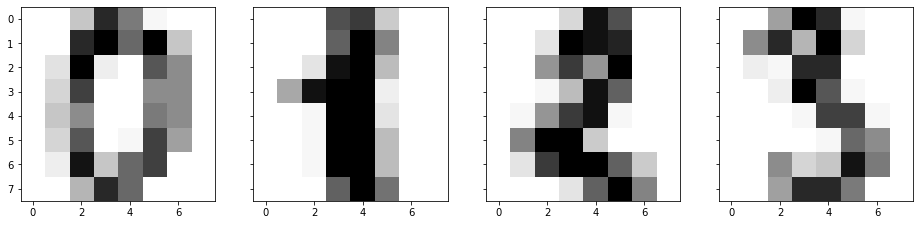

In [142]:
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16,6))
for i in range(4):    
    axes[i].imshow(X[i,:].reshape([8,8]), cmap='Greys');

Подивимося на співвідношення класів у вибірці, бачимо, що усіх цифр приблизно порівну: нулів, одиниць, ..., дев'яток.

In [143]:
np.bincount(y)

array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180], dtype=int64)

Виділимо 70% вибірки (X_train, y_train) під навчання і 30% - під відкладену вибірку (X_holdout, y_holdout), аналогічно до попереднього прикладу.

In [144]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,
                                                          random_state=17)

Навчимо дерево рішень і knn, параметри встановлюємо навмання.

In [145]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

In [146]:
%%time
tree.fit(X_train, y_train)

Wall time: 10 ms


DecisionTreeClassifier(max_depth=5, random_state=17)

In [147]:
%%time
knn.fit(X_train, y_train)

Wall time: 996 µs


KNeighborsClassifier(n_neighbors=10)

Зробимо прогнози для відкладеної вибірки. Бачимо, що метод найближчих сусідів впорався значно краще. Але це ми поки вибирали параметри навмання.

In [148]:
tree_pred = tree.predict(X_holdout)
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred), accuracy_score(y_holdout, tree_pred)

(0.9740740740740741, 0.6666666666666666)

Тепер, як і раніше, налаштуємо параметри моделей на крос-валідації, тільки врахуємо, що ознак зараз більше, ніж в минулому завданні, а саме 64.

In [149]:
tree_params = {'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
               'max_features': [1, 2, 3, 5, 10, 20 ,30, 50, 64]}

In [150]:
tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, n_jobs=-1,
                        verbose=True)

In [151]:
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
                         'max_features': [1, 2, 3, 5, 10, 20, 30, 50, 64]},
             verbose=True)

Краще поєднання параметрів і відповідна середня частка правильних відповідей на крос-валідації:

In [152]:
tree_grid.best_params_, tree_grid.best_score_

({'max_depth': 10, 'max_features': 50}, 0.8568203376968316)

In [153]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.8425925925925926

Це вже не 66%, але і не 97%. Метод найближчих сусідів на цьому наборі даних працює краще. За одного найближчого сусіда на крос-валідації досягається майже 99% вгадувань.

In [154]:
np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=1), X_train, y_train, cv=5))

0.9864858028204642

In [155]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
accuracy_score(y_holdout, knn.predict(X_holdout))

0.9833333333333333

Обучим на этих же данных случайный лес, он на большинстве выборок работает лучше, чем метод ближайших соседей. Но сейчас у нас исключение. 

In [156]:
np.mean(cross_val_score(RandomForestClassifier(random_state=17), X_train, y_train, cv=5))

0.9753462341111744

In [157]:
rf = RandomForestClassifier(random_state=17, n_jobs=-1).fit(X_train, y_train)
accuracy_score(y_holdout, rf.predict(X_holdout))

0.9666666666666667

Ви матимете рацію, якщо заперечите, що ми тут не налаштовували параметри RandomForestClassifier, але навіть з налаштуванням частка правильних відповідей не досягає 98%, як для методу одного найближчого сусіда.

Результати експерименту:

|   algo\eval      |   CV  | Holdout |  
|---------|-------|---------|
| **DT**  | 0.844 |  0.838  |  
| **kNN** | 0.987 |  0.983  |
| **RF**  | 0.935 |  0.941  | 

Позначення: CV и Holdout – середні частки правильних відповідей моделі на крос-валідації і відкладеній вибірці, відповідно. DT – дерево рішень, knn – метод найближчих сусідів, RF – випадковий ліс.

**Висновок** щодо цього експерименту (і загальна порада): на початку моделювання перевіряйте на своїх даних прості моделі - дерево рішень і метод найближчих сусідів (а далі ми ще розглянемо логістичну регресію); може виявитися, що вже вони працюють досить добре.

<a class="anchor" id="3.5"></a>

## <span style="color:blue; font-size:1.2em;">3.5. Складний випадок для дерев</span>

[Повернутися до змісту](#3)

В продовження обговорення переваг і недоліків наведемо дуже простий приклад задачі класифікації, з якою дерево справляється, але робить все якось "складніше", ніж хотілося б. Створимо множину точок на площині (2 ознаки), кожна точка налажетиме одному з класів (+1, червоні, або -1 – жовті). Якщо дивитися на це як на задачу класифікації, то начебто все дуже просто - класи розділяються прямою.

In [158]:
def form_linearly_separable_data(n=500, x1_min=0, x1_max=30, x2_min=0, x2_max=30):
    data, target = [], []
    for i in range(n):
        x1, x2 = np.random.randint(x1_min, x1_max), np.random.randint(x2_min, x2_max)
        
        if np.abs(x1 - x2) > 0.5:
            data.append([x1, x2])
            target.append(np.sign(x1 - x2))
    return np.array(data), np.array(target)

In [159]:
X, y = form_linearly_separable_data()

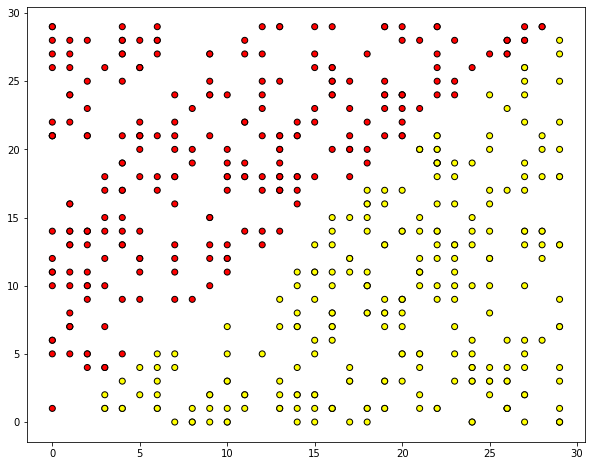

In [160]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolors='black');

Проте дерево рішень будує аж надто складну границю і тому виявляється глибоким. Крім того, уявіть, як погано дерево буде узагальнюватися на простір поза поданого квадрату $30\times30$, що обмежує навчальну вибірку.

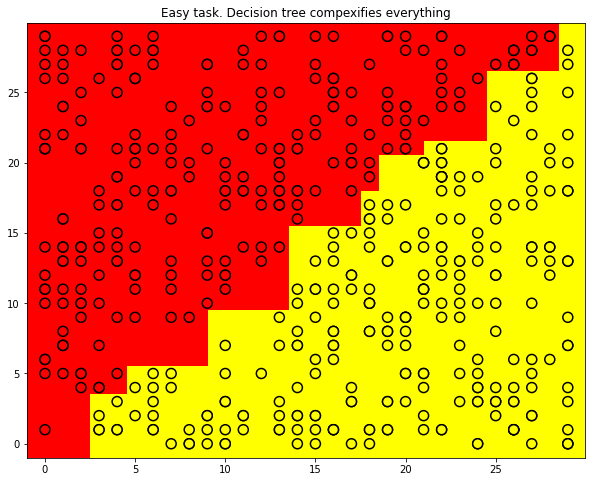

In [161]:
tree = DecisionTreeClassifier(random_state=17).fit(X, y)

xx, yy = get_grid(X, eps=.05)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.title('Easy task. Decision tree compexifies everything');

Ось така складна конструкція, хоча розв'язок (поверхня, що добре розділяє на класи) - це всього лише пряма $x_1 = x_2$.

In [162]:
dot_data = StringIO()
export_graphviz(tree, feature_names=['x1', 'x2'], 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x06\x8f\x00\x00\x03\x91\x08\x06\x00\x00\x00#\xe2;\xa…

<!--
export_graphviz(tree, feature_names=['x1', 'x2'], 
                out_file='../../img/deep_toy_tree.dot', filled=True)
!dot -Tpng '../../img/deep_toy_tree.dot' -o '../../img/deep_toy_tree.png'

<img src='../../img/deep_toy_tree.png'>
-->

Метод одного найближчого сусіда тут справляється начебто краще дерева, але все ж не так добре, як лінійний класифікатор (наша наступна тема).

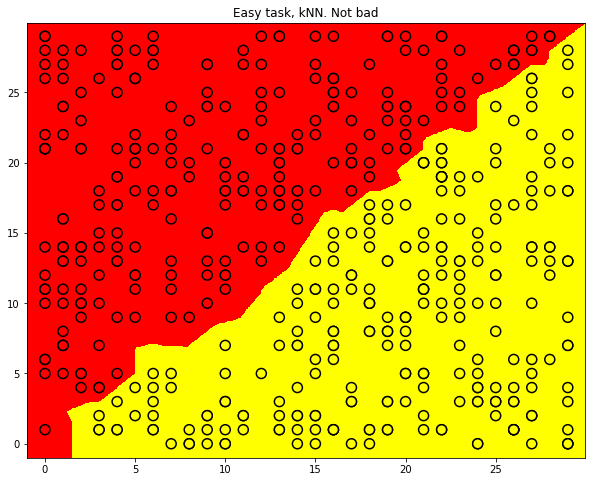

In [163]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X, y)

xx, yy = get_grid(X, eps=.05)
predicted = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);
plt.title('Easy task, kNN. Not bad');

Тепер розглянемо ще один простий приклад. У задачі класифікації одна з ознак буде просто пропорційна вектору відповідей, але методу найближчих сусідів це не допоможе.

<a class="anchor" id="3.6"></a>

## <span style="color:blue; font-size:1.2em;">3.6. Складний випадок для методу найближчих сусідів</span>

[Повернутися до змісту](#3)

In [164]:
def form_noisy_data(n_obj=1000, n_feat=100, random_seed=17):
    np.seed = random_seed
    y = np.random.choice([-1, 1], size=n_obj)
    
    # перша ознака пропорційна цільовій
    x1 = 0.3 * y
    
    # інші ознаки - шум
    
    x_other = np.random.random(size=[n_obj, n_feat - 1])
    
    return np.hstack([x1.reshape([n_obj, 1]), x_other]), y

In [165]:
X, y = form_noisy_data()

Як зазвичай, будемо дивитися на частку правильних відповідей на крос-валідації і на відкладеній вибірці. Побудуємо криві, що відображають залежність цих величин від параметра `n_neighbors` в методі найближчих сусідів. Такі криві називаються кривими валідації.

In [166]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,
                                                          random_state=17)

Нижче бачимо, що метод найближчих сусідів з евклідовою метрикою не розв'язує задачу, навіть якщо змінювати кількість найближчих сусідів в широкому діапазоні. Натомість, дерево рішень легко "виявляє" приховану залежність в даних за будь-якого обмеження на максимальну глибину.

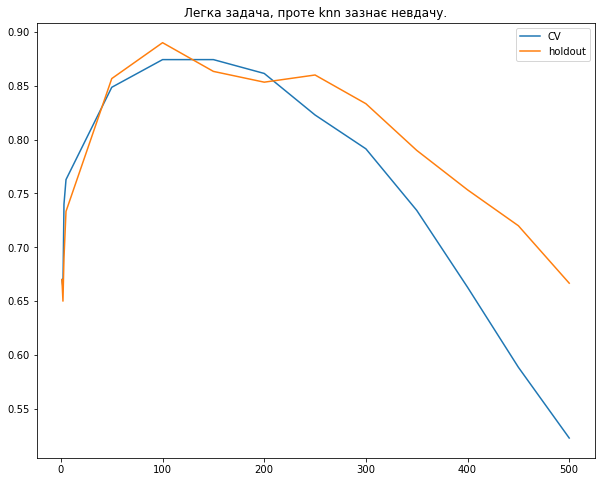

In [167]:
from sklearn.model_selection import cross_val_score

cv_scores, holdout_scores = [], []
n_neighb = [1, 2, 3, 5] + list(range(50, 550, 50))

for k in n_neighb:

    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores.append(np.mean(cross_val_score(knn, X_train, y_train, cv=5)))
    knn.fit(X_train, y_train)
    holdout_scores.append(accuracy_score(y_holdout, knn.predict(X_holdout)))

plt.plot(n_neighb, cv_scores, label='CV')
plt.plot(n_neighb, holdout_scores, label='holdout')
plt.title('Легка задача, проте knn зазнає невдачу.')
plt.legend();

In [168]:
tree = DecisionTreeClassifier(random_state=17, max_depth=1)
tree_cv_score = np.mean(cross_val_score(tree, X_train, y_train, cv=5))
tree.fit(X_train, y_train)
tree_holdout_score = accuracy_score(y_holdout, tree.predict(X_holdout))
print('Decision tree. CV: {}, holdout: {}'.format(tree_cv_score, tree_holdout_score))

Decision tree. CV: 1.0, holdout: 1.0


Отже, у другому прикладі дерево впоралося із задачею ідеально, а метод найближчих сусідів зазнав складнощей. Утім, це недолік не так методу, як використовуваної евклідової метрики: в даному випадку вона не дала змогу виявити, що одна ознака значно краща за іншу.

<a class="anchor" id="3.7"></a>

## <span style="color:blue; font-size:1em;">3.7. Корисні покликання</span>

[Повернутися до змісту](#3)

 - [Supervised Learning](https://en.wikipedia.org/wiki/Supervised_learning)
 - [Unsupervised Learning](https://en.wikipedia.org/wiki/Unsupervised_learning)
 - [Machine Learning Basics](https://www.deeplearningbook.org/contents/ml.html)
 - [The Complete Guide to Decision Trees](https://www.explorium.ai/blog/the-complete-guide-to-decision-trees/)
 - [Top 10 algorithms in data mining](https://www.researchgate.net/publication/29467751_Top_10_algorithms_in_data_mining)
 - [Энтропия и деревья принятия решений](https://habr.com/ru/post/171759/)
 - [Heuristic (computer science)](https://en.wikipedia.org/wiki/Heuristic_(computer_science))
 - [Model evaluation, model selection, and algorithm selection in machine learning](https://sebastianraschka.com/blog/2016/model-evaluation-selection-part1.html)
 - [4 Types of Classification Tasks in Machine Learning](https://machinelearningmastery.com/types-of-classification-in-machine-learning/)
 - [An introduction to machine learning with scikit-learn](https://scikit-learn.org/stable/tutorial/basic/tutorial.html)